## Data collection

In [1]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

Preview how the dataset is organized. Lines prepended by "#" are just metadata information.

In [2]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


## Imports

In [3]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

## Dataset splitting

In [4]:
base_path = "/content/data"
words_list = []
test_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

# test = open(f"{base_path}/words.txt", "r").readlines()
# for line in test:
#   test_list.append(line)

print(len(words_list))

np.random.shuffle(words_list)

96456


In [5]:
print(words_list[0:100])

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n', 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n', 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n', 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n', 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n', 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy\n', 'n03-082-04-03 ok 165 992 1414 118 135 NN boy\n', 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The\n', 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and\n', 'f04-024-01-06 ok 183 1104 981 60 70 IN in\n', 'g06-050k-00-07 ok 156 1842 717 85 76 PP$ his\n', 'm01-100-01-06 ok 185 1459 880 177 131 JJ flying\n', 'n02-033-04-01 ok 149 940 1486 353 85 VBD presented\n', 'p03-047-00-01 ok 191 393 739 127 80 UH No\n', 'g06-011e-08-00 ok 154 386 2190 70 44 CS as\n', 'p02-000-00-02 ok 182 752 727 97 85 AP few\n', 'c01-009-08-03 ok 182 1387 2363 170 81 NN work\n', 'c04-156-01-04 ok 175 989 912 65 142 INO of\n', 'h02-004-09-01 ok 191 776 2424 191 76 NNS items\n', 'g06-037o-03-02 ok 188 850 1274 214 

We will split the dataset into three subsets with a 90:5:5 ratio (train:validation:test).

In [6]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]
# test_samples = test_list

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
# validation_samples =  words_list[split_idx:]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [7]:
print(test_samples)

['g01-067-03-02 ok 152 832 1308 286 82 VBN altered\n', 'm04-093-07-01 ok 168 389 1987 154 75 RN Here\n', "l04-179-05-00 ok 169 329 1618 7 22 *' '\n", 'b05-038-01-00 ok 151 329 879 147 69 ATI the\n', 'l04-163-04-08 ok 158 1881 1448 35 54 PP3 It\n', 'l07-135-07-04 ok 180 1619 2194 106 72 IN up\n', 'e04-022-06-05 ok 172 1455 1815 204 152 NNS edges\n', 'e02-014-01-00 ok 195 302 903 139 67 ATI The\n', 'e04-022-02-03 ok 173 1015 1120 283 120 NN position\n', 'e04-038-04-04 ok 190 1023 1448 355 77 VBN scratched\n', "n04-039-05-07 ok 170 1437 1599 336 120 NN$ officer's\n", 'b06-100-07-03 ok 171 1415 2185 69 54 TO to\n', 'f04-016-00-06 ok 147 1760 694 95 104 JJ late\n', 'p02-081-02-04 ok 182 925 1272 341 56 VBD wanted\n', 'h04-071-05-02 ok 162 669 1685 13 24 , ,\n', 'f07-084a-10-03 ok 163 1112 2673 290 50 JJ Green\n', 'c01-014-04-05 ok 182 1414 1625 439 123 NN inspiration\n', 'l07-138-06-05 ok 180 1389 1878 8 9 . .\n', 'a06-051-04-05 ok 148 1338 1444 106 63 PP3A He\n', 'g06-050h-06-00 ok 182 320

## Data input pipeline

We start building our data input pipeline by first preparing the image paths.

Here in the case of input we pass in the **test_samples** which we previously segregated to create a database

In [8]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
# test_img_paths, test_labels = get_image_paths_and_labels(test_samples)
test_img_paths, test_labels = ['data/wordsT/word.png','data/wordsT/word.jpg','data/wordsT/meetings.jpeg'],['word WORD','word WORD','meetings MEETINGS']

In [9]:
print(test_img_paths)

['data/wordsT/word.png', 'data/wordsT/word.jpg', 'data/wordsT/meetings.jpeg']


In [10]:
print(test_labels)

['word WORD', 'word WORD', 'meetings MEETINGS']


In [11]:
print(test_img_paths)

['data/wordsT/word.png', 'data/wordsT/word.jpg', 'data/wordsT/meetings.jpeg']


In [12]:
print(test_labels)

['word WORD', 'word WORD', 'meetings MEETINGS']


Then we prepare the ground-truth labels.

In [13]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

Now we clean the validation and the test labels as well.

In [14]:

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)
# test_labels_cleaned = test_labels.split()[1]

In [15]:
print(test_labels_cleaned)

['WORD', 'WORD', 'MEETINGS']


In [16]:
print(test_labels)

['word WORD', 'word WORD', 'meetings MEETINGS']


In [17]:
print(test_labels_cleaned)

['WORD', 'WORD', 'MEETINGS']


In [19]:
print(validation_labels)

['b01-136-01-01 ok 182 511 915 132 91 JJ able', 'a04-019-05-11 ok 172 2060 1802 93 117 JJ full', 'g04-088-05-05 ok 172 1375 1678 6 5 . .', 'c03-096d-07-03 ok 169 978 2036 140 62 VB act', 'r03-035-04-05 ok 204 998 1449 143 120 PP2 you', 'j04-035-05-03 ok 169 1004 1666 306 57 JJ National', 'b04-000-03-03 ok 182 1100 1234 19 6 *- -', 'p03-069-03-06 ok 203 1403 1305 140 85 NN abyss', 'k02-029-05-03 ok 182 754 1807 152 53 VBD said', 'j04-015-04-07 ok 174 2092 1449 59 75 IN in', 'a03-063-01-06 ok 191 1405 1031 230 52 NN Aviation', 'n02-000-07-05 ok 174 1175 2028 7 6 . .', 'a05-058-06-03 ok 181 1296 1821 71 51 IN in', 'h07-066b-00-04 ok 165 1084 717 233 112 NN Ministry', 'a01-068u-00-05 ok 168 1573 765 160 52 ATI the', 'm04-190-04-06 ok 168 1469 1626 314 68 RB otherwise', 'n06-092-01-08 ok 181 1645 934 10 54 PP1A I', 'g06-050k-08-03 ok 156 803 2179 222 78 VBZ appears', 'c03-021b-06-01 ok 151 458 2030 79 89 INO of', 'g06-042f-00-04 ok 191 857 723 57 60 BE be', 'b06-068-08-03 ok 189 1134 2192 3

### Building the character vocabulary

Keras provides different preprocessing layers to deal with different modalities of data.
[This guide](https://keras.io/guides/preprocessing_layers/) provides a comprehensive introduction.
Our example involves preprocessing labels at the character
level. This means that if there are two labels, e.g. "cat" and "dog", then our character
vocabulary should be {a, c, d, g, o, t} (without any special tokens). We use the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/)
layer for this purpose.

In [18]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

### Resizing images without distortion

Instead of square images, many OCR models work with rectangular images. This will become
clearer in a moment when we will visualize a few samples from the dataset. While
aspect-unaware resizing square images does not introduce a significant amount of
distortion this is not the case for rectangular images. But resizing images to a uniform
size is a requirement for mini-batching. So we need to perform our resizing such that
the following criteria are met:

* Aspect ratio is preserved.
* Content of the images is not affected.

In [19]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


If we just go with the plain resizing then the images would look like so:

![](https://i.imgur.com/eqq3s4N.png)

Notice how this resizing would have introduced unnecessary stretching.

### Putting the utilities together

In [20]:
batch_size = 64
padding_token = 99

image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


## Prepare `tf.data.Dataset` objects

In [21]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

In [22]:
print(test_ds)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


In [23]:
print(validation_labels_cleaned)

['able', 'full', '.', 'act', 'you', 'National', '-', 'abyss', 'said', 'in', 'Aviation', '.', 'in', 'Ministry', 'the', 'otherwise', 'I', 'appears', 'of', 'be', 'expose', 'Defence', 'our', 'gesture', 'you', ',', 'Nor', '.', 'to', 'say', '"', 'about', 'us', 'economic', 'the', 'had', 'only', 'and', 'few', 'robbery', 'By', 'Week', 'circumstances', 'holds', 'Soil', '"', 'occur', '.', 'Jeannie', 'end', 'written', 'photographs', 'on', 'great', '?', 'to', 'public', 'of', '1960s', 'and', 'And', 'regarded', 'told', ',', 'finger', 'an', 'His', 'spend', 'One', 'heart', ',', 'opportunities', 'way', ',', 'to', 'only', 'saying', 'conventional', 'bases', 'on', '.', 'This', 'been', 'I', 'verse', 'deterioration', 'even', 'was', 'who', 'week', 'thing', '.', 'and', 'way', 'cluster', 'evening', '.', 'assumption', 'teach', 'Peacock', 'was', 'on', 'to', '.', 'predatory', 'of', 'the', 'was', 'of', 'their', '.', 'Britain', 'his', '?', 'Diefen-', '1/4', 'in', ';', 'to', 'Americans', 'must', 'correspond', 'way', 

## Visualize a few samples

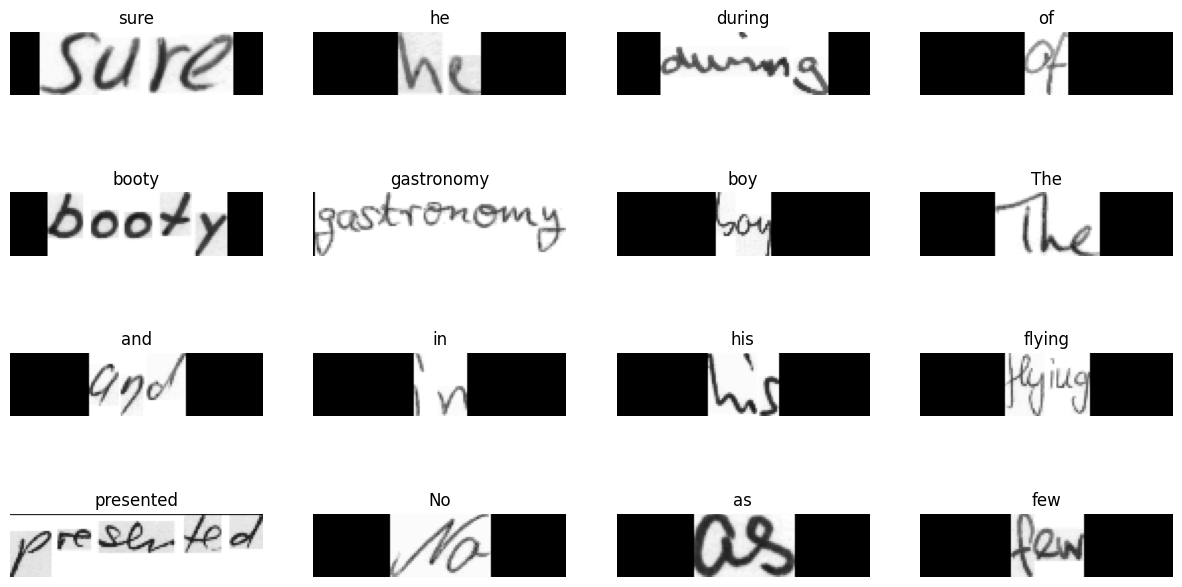

In [24]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

You will notice that the content of original image is kept as faithful as possible and has
been padded accordingly.

## Model

Our model will use the CTC loss as an endpoint layer. For a detailed understanding of the
CTC loss, refer to [this post](https://distill.pub/2017/ctc/).

In [25]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

## Evaluation metric

[Edit Distance](https://en.wikipedia.org/wiki/Edit_distance)
is the most widely used metric for evaluating OCR models. In this section, we will
implement it and use it as a callback to monitor our model.

We first segregate the validation images and their labels for convenience.

In [26]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [27]:
print(validation_labels)

[<tf.Tensor: shape=(64, 21), dtype=int64, numpy=
array([[53, 54, 64, ..., 99, 99, 99],
       [58, 73, 64, ..., 99, 99, 99],
       [12, 99, 99, ..., 99, 99, 99],
       ...,
       [70, 57, 59, ..., 99, 99, 99],
       [72, 67, 64, ..., 99, 99, 99],
       [10, 99, 99, ..., 99, 99, 99]])>, <tf.Tensor: shape=(64, 21), dtype=int64, numpy=
array([[58, 61, 66, ..., 99, 99, 99],
       [53, 66, 99, ..., 99, 99, 99],
       [34, 61, 71, ..., 99, 99, 99],
       ...,
       [71, 72, 70, ..., 99, 99, 99],
       [25, 99, 99, ..., 99, 99, 99],
       [54, 53, 55, ..., 99, 99, 99]])>, <tf.Tensor: shape=(64, 21), dtype=int64, numpy=
array([[71, 67, 99, ..., 99, 99, 99],
       [60, 61, 71, ..., 99, 99, 99],
       [67, 58, 99, ..., 99, 99, 99],
       ...,
       [75, 61, 58, ..., 99, 99, 99],
       [12, 99, 99, ..., 99, 99, 99],
       [72, 61, 56, ..., 99, 99, 99]])>, <tf.Tensor: shape=(64, 21), dtype=int64, numpy=
array([[72, 60, 70, ..., 99, 99, 99],
       [57, 58, 58, ..., 99, 99, 99],
  

Now, we create a callback to monitor the edit distances.

In [28]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


## Training

Now we are ready to kick off model training.

In [32]:
# pip install livelossplot

In [29]:
epochs = 10  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Epoch 1/10
  22/1357 [..............................] - ETA: 15:46 - loss: 41.1607

KeyboardInterrupt: ignored

In [ ]:
history.history.keys()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train_ds'],loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_ds'],loc='upper left')
plt.show()

In [ ]:
# from livelossplot import PlotLossesKeras

# model.fit(train_ds,
#           epochs=1,
#           validation_data=validation_ds,
#           callbacks=[PlotLossesKeras()],
#           verbose=0)

## Inference

In [ ]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(3):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
print(test_ds.take(1))

To get better results the model should be trained for at least 50 epochs.

## Final remarks

* The `prediction_model` is fully compatible with TensorFlow Lite. If you are interested,
you can use it inside a mobile application. You may find
[this notebook](https://github.com/tulasiram58827/ocr_tflite/blob/main/colabs/captcha_ocr_tflite.ipynb)
to be useful in this regard.
* Not all the training examples are perfectly aligned as observed in this example. This
can hurt model performance for complex sequences. To this end, we can leverage
Spatial Transformer Networks ([Jaderberg et al.](https://arxiv.org/abs/1506.02025))
that can help the model learn affine transformations that maximize its performance.